In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

# Core learnig algorithms

- Linear Regression
- Classification
- Clustering
- Hidden Markov Models

## Linear regresion

(0.0, 6.0, 0.0, 20.0)

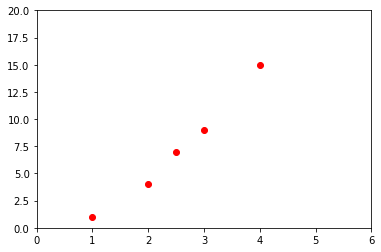

In [2]:
x = [1, 2, 2.5, 3, 4]
y = [1, 4, 7, 9, 15]
plt.plot(x, y, 'ro')
plt.axis([0, 6, 0, 20])

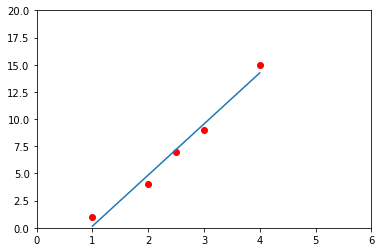

In [3]:
plt.plot(x, y, 'ro')
plt.axis([0, 6, 0, 20])
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.show()

Load Titanic dataset

In [4]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data

In [5]:
dftrain.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


Separate survived data

In [6]:
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [7]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [8]:
print(dftrain.loc[0], y_train.loc[0]) # 0 at the end is y_train

sex                          male
age                          22.0
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object 0


In [9]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [10]:
dftrain.shape

(627, 9)

In [11]:
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

Some graphs

<AxesSubplot:>

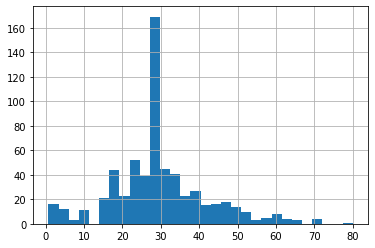

In [12]:
dftrain.age.hist(bins=30)

<AxesSubplot:>

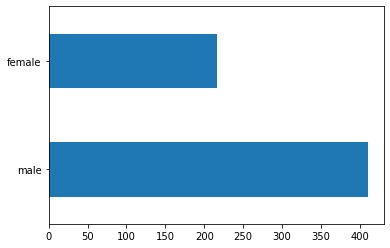

In [13]:
dftrain.sex.value_counts().plot(kind='barh')

<AxesSubplot:>

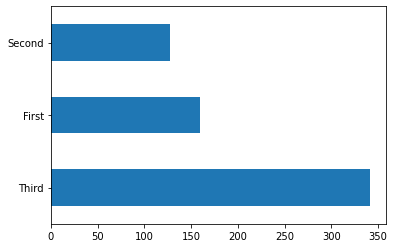

In [14]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

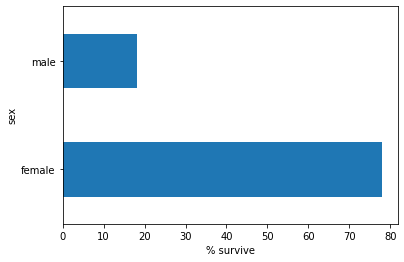

In [15]:
# pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')
(pd.concat([dftrain, y_train], axis = 1).groupby('sex').survived.mean()*100).plot(kind='barh').set_xlabel('% survive')

Training and Testing data

In [16]:
dftrain.shape

(627, 9)

In [17]:
dfeval.shape

(264, 9)

Feature colums

In [18]:
CATEGORICAL_COLUMS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

In [19]:
print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

Training

In [20]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

Creating the model

In [21]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\User\\AppData\\Local\\Temp\\tmpo1s6jg1a', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Train model

In [22]:
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result['accuracy'])

0.75


In [23]:
print(result)

{'accuracy': 0.75, 'accuracy_baseline': 0.625, 'auc': 0.82724214, 'auc_precision_recall': 0.7924358, 'average_loss': 0.517798, 'label/mean': 0.375, 'loss': 0.5148925, 'precision': 0.6386555, 'prediction/mean': 0.47925147, 'recall': 0.7676768, 'global_step': 200}


Making predictions

<AxesSubplot:title={'center':'predicted probabilities of survival'}, ylabel='Frequency'>

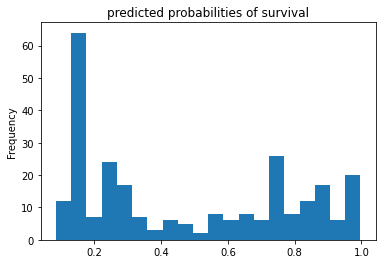

In [24]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

clear_output()
probs.plot(kind='hist', bins=20, title='predicted probabilities of survival')

In [25]:
i = 5
print(dfeval.loc[i])
print(y_eval.loc[i])
print(pred_dicts[i]['probabilities'][1])

sex                       female
age                         15.0
n_siblings_spouses             0
parch                          0
fare                      8.0292
class                      Third
deck                     unknown
embark_town           Queenstown
alone                          y
Name: 5, dtype: object
1
0.79030025


## Classification

In [26]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']

train_path = tf.keras.utils.get_file("iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file("iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)

Looking at the data and separating

In [27]:
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [28]:
train_y = train.pop('Species')
test_y = test.pop('Species')
train.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth
0,6.4,2.8,5.6,2.2
1,5.0,2.3,3.3,1.0
2,4.9,2.5,4.5,1.7
3,4.9,3.1,1.5,0.1
4,5.7,3.8,1.7,0.3


In [29]:
train.shape

(120, 4)

Input function

In [30]:
def input_fn(features, labels, training=True, batch_size=256):
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)

Feature colums

In [31]:
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
print(my_feature_columns)

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


Building the model

In [32]:
classifier = tf.estimator.DNNClassifier(feature_columns=my_feature_columns, hidden_units=[30, 10], n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\User\\AppData\\Local\\Temp\\tmpx1kn1zxm', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Training the classifier

In [33]:
classifier.train(input_fn=lambda: input_fn(train, train_y, training=True), steps=10000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\User\AppData\Local\Temp\tmpx1kn1zxm\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 1.0372196, step = 0
INFO:tensorflow:global_step/sec: 468.196
INFO:tensorflow:loss = 0.6707829, step = 100 (0.214 sec)
INFO:tensorflow:global_step/sec: 494.831
INFO:tensorflow:loss = 0.61809397, step = 200 (0.203 sec)
INFO:tensorflow:global_step/sec: 590.289
INFO:tensorflow:loss = 0.5927912, step = 300 (0.168 sec)
INFO:tensorflow:global_step/sec: 608.457
INFO:tensorflow:loss = 0.5755079, step = 400 (0.164 sec)
INFO:tensorflow:global_step/sec: 605.47
INFO:tensorflow:loss = 0.5611237, s

Evaluating the classifier

In [34]:
eval_result = classifier.evaluate(input_fn=lambda: input_fn(test, test_y, training=False))

print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-11-17T01:50:58
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\User\AppData\Local\Temp\tmpx1kn1zxm\model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.24754s
INFO:tensorflow:Finished evaluation at 2021-11-17-01:50:58
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.93333334, average_loss = 0.26211625, global_step = 10000, loss = 0.26211625
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: C:\Users\User\AppData\Local\Temp\tmpx1kn1zxm\model.ckpt-10000

Test set accuracy: 0.933



Making predictions

In [35]:
def input_fn(features, batch_size=256):
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict = {}

print("Please type numeric values as prompted.")
for feature in features:
    valid = True
    while valid: 
        val = input(feature + ": ")
        if not val.isdigit(): valid = False
    print(feature, ':', val)

    predict[feature] = [float(val)]

predictions = classifier.predict(input_fn=lambda: input_fn(predict))
for pred_dict in predictions:
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print('Prediction is "{}" ({:.1f}%)'.format(
        SPECIES[class_id], 100 * probability))

Please type numeric values as prompted.
SepalLength : 2.4
SepalWidth : 2.6
PetalLength : 6.5
PetalWidth : 6.3
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\User\AppData\Local\Temp\tmpx1kn1zxm\model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction is "Virginica" (98.3%)


## Clustering